Steam User Analysis - Zac Reid

Takes a JSON file of steam users to perform analysis (from steam_scrape.ipynb)
#################################################################################

In [80]:
%%capture
# Import / Install packages, set env vars. and declare global vars.


%load_ext autoreload
%autoreload 2
%pip install networkx seaborn igraph-python matplotlib

k4 = (3840, 2160)
k2 = (2560, 1440)
k1 = (1920, 1080)

from SteamUser import *
import json
import networkx as nx
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import os

In [47]:
# Import JSON data
users = {}
filename = "users22k3.json"
nickname = filename.split(".")[0]
plotfile = "plots\\" + nickname

os.makedirs(plotfile, exist_ok=True)


with open(filename, "r") as file:
    for l in file.readlines():
        u = SteamUser.fromdict(json.loads(l))
        users[u.steamID] = u
    file.close()

print("Collected {} users from file!".format(len(users)))

Collected 22131 users from file!


In [48]:
# Create networkx graph with attributes

G = nx.Graph()
G.add_nodes_from([u for u in users if users[u].friends != None and len(users[u].friends) > 0])
G.add_edges_from([[u.steamID, f] for u in users.values() if u.friends != None and len(u.friends) > 0 for f in u.friends if f in users and users[f].friends != None and len(users[f].friends) > 0 ])
nx.set_node_attributes(G, dict(((u, users[u].asdict()) for u in users if users[u].friends != None and len(users[u].friends) > 0)))
print("Created a graph with {} nodes and {} edges!".format(G.number_of_nodes(), G.number_of_edges()))

Created a graph with 16308 nodes and 110685 edges!


In [49]:
# Create igraph network that references our networkx graph

g = ig.Graph.from_networkx(G)

In [51]:
# Try and fit powerlaw

r = ig.statistics.power_law_fit(g.vs["level"])
print(r)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 3.129416
Cutoff (xmin)     = 50.000000

Log-likelihood    = -7491.611983

H0: data was drawn from the fitted distribution

KS test statistic = 0.027932
p-value           = 0.158848

H0 could not be rejected at significance level 0.05


In [52]:
# Try and fit powerlaw

r = ig.statistics.power_law_fit(len(f) for f in g.vs["friends"] if type(f) != None)
print(r)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 4.654745
Cutoff (xmin)     = 297.000000

Log-likelihood    = -6298.978896

H0: data was drawn from the fitted distribution

KS test statistic = 0.016966
p-value           = 0.906395

H0 could not be rejected at significance level 0.05


In [53]:
# Try and fit powerlaw

r = ig.statistics.power_law_fit(g.degree())
print(r)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.981290
Cutoff (xmin)     = 40.000000

Log-likelihood    = -5289.073222

H0: data was drawn from the fitted distribution

KS test statistic = 0.034193
p-value           = 0.127846

H0 could not be rejected at significance level 0.05


In [59]:
# Create plot of network

g_layout = g.layout_lgl()
att = {
    'bbox': k4,
    'target': (plotfile + "\\default_plot_" + nickname + ".png"),
    'edge_with': 1,
    'edge_color': 'grey',
    'vertex_size': 20,
    'vertex_color': 'royalblue',
}
ig.plot(g, layout=g_layout, **att)
print("Created plot")

Created plot


Max: 1996, Min: 1, Mean: 119.9860191317145, Median: 88.0, Mode: 1, Range: (1, 1996)


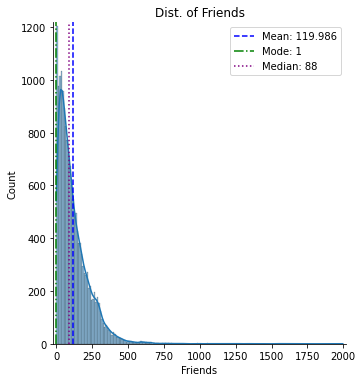

In [58]:
#Distribution Of Friends

number_of_friends = [len(f) for f in g.vs["friends"]]

mx = max(number_of_friends)
mn = min(number_of_friends)
mean = sum(number_of_friends) / len(number_of_friends)
median = statistics.median(number_of_friends)
mode = statistics.mode(number_of_friends)
range = (mn, mx)
print("Max: {}, Min: {}, Mean: {}, Median: {}, Mode: {}, Range: {}".format(mx, mn, mean, median, mode, range))

sns.displot(number_of_friends, kde=True)
m1 = plt.axvline(mean, color="blue", linestyle='--' ,label="Mean: {}".format(round(mean, 3)))
m2 = plt.axvline(mode, color="green", linestyle='-.' ,label="Mode: {}".format(mode))
m3 = plt.axvline(median, color="purple", linestyle=':' ,label="Median: {}".format(int(median)))

plt.xlabel("Friends")
plt.title("Dist. of Friends")
plt.margins(0.01)
plt.legend(loc=0)

plt.savefig(fname=(plotfile + "\\friend_dist_" + nickname + ".png"))

Max: 1111, Min: 0, Mean: 23.20775079715477, Median: 13.0, Mode: 10, Range: (0, 1111)


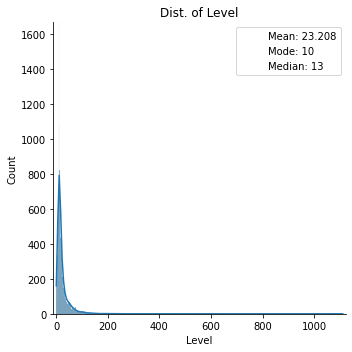

In [60]:
#Distibution of level

user_levels = [l or 0 for l in g.vs["level"]]

mx = max(user_levels)
mn = min(user_levels)
mean = sum(user_levels) / len(user_levels)
median = statistics.median(user_levels)
mode = statistics.mode(user_levels)
range = (mn, mx)
print("Max: {}, Min: {}, Mean: {}, Median: {}, Mode: {}, Range: {}".format(mx, mn, mean, median, mode, range))

sns.displot(user_levels, kde=True)
m1 = plt.axvline(mean, color="blue", linestyle='--' ,label="Mean: {}".format(round(mean, 3)), linewidth=0)
m2 = plt.axvline(mode, color="green", linestyle='-.' ,label="Mode: {}".format(mode), linewidth=0)
m3 = plt.axvline(median, color="purple", linestyle=':' ,label="Median: {}".format(int(median)), linewidth=0)

plt.xlabel("Level")
plt.title("Dist. of Level")
plt.margins(0.01)
plt.legend(loc=0)
plt.tight_layout()
plt.ylim(0,user_levels.count(mode) + 20)

plt.savefig(fname=(plotfile + "\\level_dist_" + nickname + ".png"))

In [61]:
#Ban Info
vac_bans = len([1 for u in g.vs["vacbanned"] if u == True])
community_bans = len([1 for u in g.vs["communitybanned"] if u == True])
economyban = len([1 for u in g.vs["economyban"] if u == True])

print("VAC Bans: {}".format(vac_bans), ", Comm. Bans: {}".format(community_bans), ", Econ. Bans {}".format(economyban))

VAC Bans: 332 , Comm. Bans: 28 , Econ. Bans 0


Max: 4419, Min: 0, Mean: 27.931317838964862, Median: 10, Mode: 0, Range: (0, 4419)


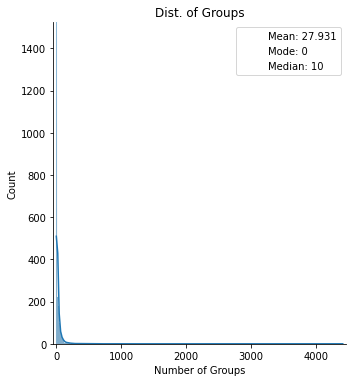

In [62]:
#Distribution Of Num. Groups

number_of_groups = [len(f) for f in g.vs["groups"] if f != None]

mx = max(number_of_groups)
mn = min(number_of_groups)
mean = sum(number_of_groups) / len(number_of_groups)
median = statistics.median(number_of_groups)
mode = statistics.mode(number_of_groups)
range = (mn, mx)
print("Max: {}, Min: {}, Mean: {}, Median: {}, Mode: {}, Range: {}".format(mx, mn, mean, median, mode, range))

sns.displot(number_of_groups, kde=True)
m1 = plt.axvline(mean, color="blue", linestyle='--' ,label="Mean: {}".format(round(mean, 3)), linewidth=0)
m2 = plt.axvline(mode, color="green", linestyle='-.' ,label="Mode: {}".format(mode), linewidth=0)
m3 = plt.axvline(median, color="purple", linestyle=':' ,label="Median: {}".format(int(median)), linewidth=0)

plt.xlabel("Number of Groups")
plt.title("Dist. of Groups")
plt.margins(0.01)
plt.ylim(0,number_of_groups.count(mode) + 50)
plt.legend(loc=0)

plt.savefig(fname=(plotfile + "\\group_dist_" + nickname + ".png"))

In [63]:
#Show Cheaters

color_dict = {True: "red", False: "royalblue", None: "grey"}

att = {
    'bbox': k4,
    'target': (plotfile + "\\show_cheaters_" + nickname + ".png"),
    'edge_with': 1,
    'edge_color': 'grey',
    'vertex_size': 20,
    'vertex_color': [color_dict[v] for v in g.vs["vacbanned"]],
}
ig.plot(g, layout=g_layout, **att)
print("Created plot")

Created plot


In [65]:
#Show Cheaters Graph with friends

color_dict = {True: "red", False: "royalblue", None: "grey"}

cheater_graph_ig = ig.Graph.from_networkx(cheater_graph)

cheater_friend_count = [len(v) for v in cheater_graph_ig.vs["friends"]]
print(max(cheater_friend_count))
print("Created a cheater graph with {} nodes and {} edges!".format(cheater_graph.number_of_nodes(), cheater_graph.number_of_edges()))
att = {
    'bbox': k4,
    'target': (plotfile + "\\cheaters_plot_" + nickname + ".png"),
    'edge_with': .1,
    'edge_color': 'grey',
    'vertex_size': 20,
    'vertex_color': [color_dict[v] for v in cheater_graph_ig.vs["vacbanned"]],
}
ig.plot(cheater_graph_ig, layout="auto", **att)
print("Created plot")

1996
Created a cheater graph with 2132 nodes and 15464 edges!
Created plot


In [66]:
#Show Cheaters Graph just cheaters

vaced_players = [u for u in users if users[u].vacbanned == True]
just_cheater_graph = G.subgraph(nodes=vaced_players)

just_cheater_graph_ig = ig.Graph.from_networkx(just_cheater_graph)
print("Created a cheater graph with {} nodes and {} edges!".format(just_cheater_graph.number_of_nodes(), just_cheater_graph.number_of_edges()))
att = {
    'bbox': k4,
    'target': (plotfile + "just_cheaters_plot_" + nickname + ".png"),
    'edge_with': .1,
    'edge_color': 'grey',
    'vertex_size': 20,
    'vertex_color': [color_dict[v] for v in just_cheater_graph_ig.vs["vacbanned"]],
}
ig.plot(just_cheater_graph_ig, layout="lgl", **att)
print("Created plot")

Created a cheater graph with 332 nodes and 27 edges!
Created plot


In [67]:
# Create pandas df from user data

import pandas as pd
data = pd.DataFrame.from_dict(users, orient='index')

In [68]:
def LEN(x):
    try:
        return len(x)
    except:
        return 0

data["friends_count"] = data["friends"].apply(LEN)


In [153]:
data

,steamID,personaname,profileurl,avatar,avatarmedium,avatarfull,personstate,communityvisibilitystate,profilestate,lastlogoff,...,level,playerxp,communitybanned,vacbanned,numberofvacbans,dayssincelastban,numberofgamebans,economyban,badges,friends_count
76561198181797235,76561198181797235,Adoufi,https://steamcommunity.com/id/dsfarfgergeg/,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,5.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 3, 'completion_time'...",5
76561197960289727,76561197960289727,I CAME HERE TO FUCK,https://steamcommunity.com/id/kalleblomkal/,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,2.0,1.0,None,...,NaN,None,False,False,0.0,0.0,0.0,none,None,0
76561198114208981,76561198114208981,A.Qubaia,https://steamcommunity.com/profiles/7656119811...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,6.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 4, 'completion_time'...",14
76561198387916507,76561198387916507,többevillknulla,https://steamcommunity.com/profiles/7656119838...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,10.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 44, 'completion_time...",42
76561198983307510,76561198983307510,gamer123,https://steamcommunity.com/profiles/7656119898...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,9.0,None,True,True,1.0,475.0,0.0,none,"[{'badgeid': 2, 'level': 3, 'completion_time':...",101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198310540785,76561198310540785,survivaL,https://steamcommunity.com/id/4iri4ka/,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,5.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 4, 'completion_time'...",40
76561198126181520,76561198126181520,Fisher51,https://steamcommunity.com/profiles/7656119812...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,13.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 21, 'completion_time...",84
76561198301968375,76561198301968375,Ramon,https://steamcommunity.com/profiles/7656119830...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,2.0,None,None,None,NaN,NaN,NaN,None,"[{'badgeid': 1, 'level': 5, 'completion_time':...",113
76561198305976777,76561198305976777,G.I Jorge,https://steamcommunity.com/profiles/7656119830...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,https://steamcdn-a.akamaihd.net/steamcommunity...,None,3.0,1.0,None,...,6.0,None,False,False,0.0,0.0,0.0,none,"[{'badgeid': 13, 'level': 4, 'completion_time'...",159


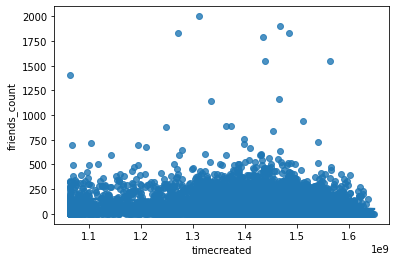

In [156]:
p = sns.regplot(x=data["timecreated"], y=data["friends_count"])

In [157]:
statistics.correlation([v or 0 for v in g.vs["timecreated"]], [len(v or []) for v in g.vs["friends"]])

-0.20558173589432263

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


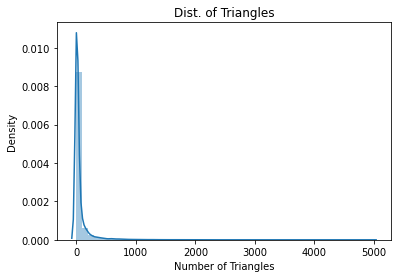

In [69]:
# Create plot of triangle dist. from our graph

sns.distplot(list(nx.triangles(G).values()), kde=True)

plt.xlabel("Number of Triangles")
plt.title("Dist. of Triangles")

plt.savefig(fname=(plotfile + "triangle_dist_" + nickname + ".png"))

In [82]:
l = [v for _,v in cheater_graph.degree()]
cl = statistics.mean(l)

j = [v for _,v in just_cheater_graph.degree()]
jcl = statistics.mean(j)

lg = [v for _,v in G.degree()]
mlg = statistics.mean(lg)

In [ ]:
acg = nx.average_clustering(G)
acc = nx.average_clustering(cheater_graph)
acjc = nx.average_clustering(just_cheater_graph)

In [168]:
d = nx.eigenvector_centrality(G).values()
statistics.median(d)

5.014058213832097e-06

In [ ]:
# Create data summary file
e = "\n"
data_summary = \
    "Default Graph -- -- " + e + \
    "Created a graph with {} nodes and {} edges!".format(G.number_of_nodes(), G.number_of_edges()) + e + \
    "VAC Bans: {}".format(vac_bans), ", Comm. Bans: {}".format(community_bans), ", Econ. Bans {}".format(economyban) + e + \
    "Avg. Degree : {}".format(mlg) + e + \
    "Avg. Clustering : {}".format(acg) + e*2 + \
    \
    "Cheater Graph -- -- " + e + \
    "Created a cheater graph with {} nodes and {} edges!".format(cheater_graph.number_of_nodes(), cheater_graph.number_of_edges()) + e + \
    "Avg. Degree : {}".format(cl) + e + \
    "Avg. Clustering : {}".format(acc) + e*2 + \
    \
    "Just Cheater Graph -- -- " + e + \
    "Created a cheater graph with {} nodes and {} edges!".format(just_cheater_graph.number_of_nodes(), just_cheater_graph.number_of_edges()) + e + \
    "Avg. Degree : {}".format(jcl) + e + \
    "Avg. Clustering : {}".format(acjc)


with open(plotfile + "\\summary" + nickname +".txt", 'w') as sf:
    sf.write(data_summary)
    sf.close()


data_summary